In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

In [95]:
# Load the dataset
file_path = r'../../data/tidy/NTD_Annual_Data_Tidy.csv'
df = pd.read_csv(file_path)

In [96]:
df.head()

,Agency,NTD ID,City,State,UZA Name,Total Operating Hours,Total Employees,Number of Operating Fleets,Ridership,Service Area Population,...,Diesel (gal),Gasoline (gal),Liquefied Petroleum Gas (gal),Compressed Natural Gas (gal),Bio Diesel (gal),Other Fuel (gal/gal equivalent),Electric Propulsion (kWh),Electric Battery (kWh),Total Diesel (gal),Total kWh
0,MTA New York City Transit,20008,Brooklyn,NY,"New York--Jersey City--Newark, NY--NJ","79,401,206","45,802",50095.0,491106831.0,8804190.0,...,"27,958,302","3,570,980",0,"4,824,913",0,0,"1,552,447,460","618,599","27,958,3023,570,98004,824,91300","1,552,447,460618,599"
1,New Jersey Transit Corporation,20080,Newark,NJ,"New York--Jersey City--Newark, NY--NJ","21,149,972","11,452",26312.0,187806013.0,10594013.0,...,"35,585,247","1,805,901",0,"1,257,636",0,0,"380,816,628",0,"35,585,2471,805,90101,257,63600","380,816,6280"
2,Washington Metropolitan Area Transit Authority,30030,Washington,DC,"Washington--Arlington, DC--VA--MD","18,010,252","13,214.21",11228.0,122883834.0,5089918.0,...,"7,351,971","1,812,002",0,"3,965,272",0,0,"438,160,464","17,194","7,351,9711,812,00203,965,27200","438,160,46417,194"
3,Los Angeles County Metropolitan Transportation...,90154,Los Angeles,CA,"Los Angeles--Long Beach--Anaheim, CA","17,905,536","10,192",17563.0,110932715.0,10394849.0,...,0,"977,648",0,"26,998,561",0,0,"187,734,358","3,635,843","0977,648026,998,56100","187,734,3583,635,843"
4,Chicago Transit Authority,50066,Chicago,IL,"Chicago, IL--IN","16,960,103","9,790",4360.0,115480485.0,3207635.0,...,"13,403,932",0,0,0,0,0,"373,727,434","302,556","13,403,93200000","373,727,434302,556"


In [97]:
# Set 'Agency' as the index and drop the other info columns
df.set_index('Agency', inplace=True)
df_features = df.drop(columns=['NTD ID', 'City', 'State', 'UZA Name'])

In [98]:
# Remove commas from numeric columns and convert to numeric
numeric_columns = df_features.columns[df_features.dtypes == 'object']
df_features[numeric_columns] = df_features[numeric_columns].replace({',': ''}, regex=True)
df_features[numeric_columns] = df_features[numeric_columns].apply(pd.to_numeric, errors='coerce')


# Fill missing values with the median of the respective columns
df_features = df_features.fillna(df_features.median())

In [99]:
df_features.columns

Index(['Total Operating Hours', 'Total Employees',
       'Number of Operating Fleets', 'Ridership', 'Service Area Population',
       'Service Area Sq Miles', 'Primary UZA Area Sq Miles', 'Diesel (gal)',
       'Gasoline (gal)', 'Liquefied Petroleum Gas (gal)',
       'Compressed Natural Gas (gal)', 'Bio Diesel (gal)',
       'Other Fuel (gal/gal equivalent)', 'Electric Propulsion (kWh)',
       'Electric Battery (kWh)', 'Total Diesel (gal)', 'Total kWh'],
      dtype='object')

In [100]:
df_features=df_features.drop(columns=['Diesel (gal)', 'Gasoline (gal)','Liquefied Petroleum Gas (gal)','Compressed Natural Gas (gal)','Bio Diesel (gal)','Other Fuel (gal/gal equivalent)','Electric Propulsion (kWh)','Electric Battery (kWh)'])

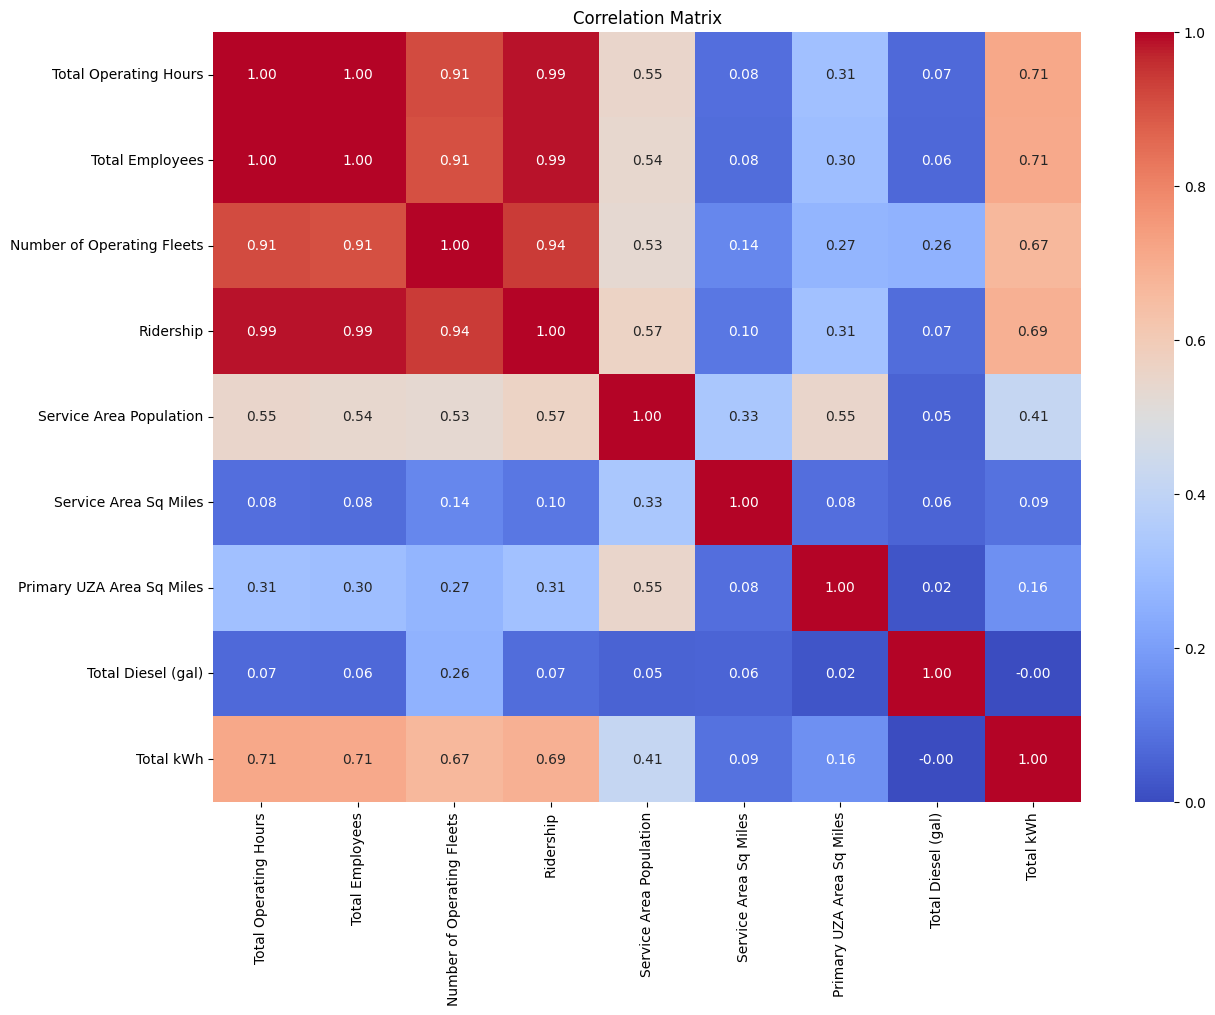

In [101]:
# Correlation Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(df_features.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Correlation matrix analsis:

## High correlation among some features:
### Total Operating Hours, Total Employees, Number of Operating Fleets, and Ridership show very high correlations (close to 1) with each other. This indicates that these variables move together and could potentially be redundant when included together in a model.

## Target variables: 
### Total kWh has a strong positive correlation with Total Operating Hours (0.71), Total Employees (0.71), Number of Operating Fleets (0.67), and Ridership (0.69). This suggests that these features are important predictors for the Total kWh.
### Total Diesel (gal) has low or negative correlations with most features, suggesting that it might be influenced by other factors not captured by the current features. This could indicate missing important predictors for diesel consumption in the dataset.

## Potential Multicollinearity:
### High correlations among Total Operating Hours, Total Employees, Number of Operating Fleets, and Ridership suggest multicollinearity. Multicollinearity can cause instability in regression models and should be addressed, possibly by removing some of these features or using techniques like Principal Component Analysis (PCA) to reduce dimensionality.

#  Basic linear regression, random forest, Ridge and Lasso:

In [102]:
# Features: all columns except 'Total Diesel (gal)' and 'Total kWh'
# Target: 'Total Diesel (gal)' and 'Total kWh'
X = df_features.drop(columns=['Total Diesel (gal)', 'Total kWh'])
y = df_features[['Total Diesel (gal)', 'Total kWh']]

In [103]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [104]:
# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [105]:
# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [106]:
# Make predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [107]:
### Fix two issus:
#1. Filter out rows with Observed Total kWh equal to zero when evaluating kWh predictions, and similarly for Total Diesel (gal).
#2. Ensure that the model predictions are non-negative.

# Ensure non-negative predictions
y_pred_lr = np.maximum(0, y_pred_lr)
y_pred_rf = np.maximum(0, y_pred_rf)

# Filter rows with non-zero observed values for MAPE calculation
non_zero_diesel = y_test['Total Diesel (gal)'] != 0
non_zero_kwh = y_test['Total kWh'] != 0

In [108]:
mape_lr_diesel = mean_absolute_percentage_error(y_test['Total Diesel (gal)'][non_zero_diesel], y_pred_lr[non_zero_diesel, 0])
mape_lr_kwh = mean_absolute_percentage_error(y_test['Total kWh'][non_zero_kwh], y_pred_lr[non_zero_kwh, 1])
mape_rf_diesel = mean_absolute_percentage_error(y_test['Total Diesel (gal)'][non_zero_diesel], y_pred_rf[non_zero_diesel, 0])
mape_rf_kwh = mean_absolute_percentage_error(y_test['Total kWh'][non_zero_kwh], y_pred_rf[non_zero_kwh, 1])

In [109]:
# Print results
print(f"Linear Regression MAPE for Total Diesel (gal): {mape_lr_diesel}")
print(f"Linear Regression MAPE for Total kWh: {mape_lr_kwh}")
print(f"Random Forest MAPE for Total Diesel (gal): {mape_rf_diesel}")
print(f"Random Forest MAPE for Total kWh: {mape_rf_kwh}")

Linear Regression MAPE for Total Diesel (gal): 5484465003239897.0
Linear Regression MAPE for Total kWh: 121647845.40430532
Random Forest MAPE for Total Diesel (gal): 132405720911640.64
Random Forest MAPE for Total kWh: 201538646.26942754


In [118]:
# Add predictions and individual MAPE to the dataset
df_results = X_test.copy()
df_results['Observed Total Diesel (gal)'] = y_test['Total Diesel (gal)']
df_results['Observed Total kWh'] = y_test['Total kWh']
df_results['Predicted Total Diesel (gal) LR'] = y_pred_lr[:, 0]
df_results['Predicted Total kWh LR'] = y_pred_lr[:, 1]
df_results['Predicted Total Diesel (gal) RF'] = y_pred_rf[:, 0]
df_results['Predicted Total kWh RF'] = y_pred_rf[:, 1]
df_results['MAPE Total Diesel (gal) LR'] = np.where(non_zero_diesel, np.abs((y_test['Total Diesel (gal)'] - y_pred_lr[:, 0]) / y_test['Total Diesel (gal)']), np.nan)
df_results['MAPE Total kWh LR'] = np.where(non_zero_kwh, np.abs((y_test['Total kWh'] - y_pred_lr[:, 1]) / y_test['Total kWh']), np.nan)
df_results['MAPE Total Diesel (gal) RF'] = np.where(non_zero_diesel, np.abs((y_test['Total Diesel (gal)'] - y_pred_rf[:, 0]) / y_test['Total Diesel (gal)']), np.nan)
df_results['MAPE Total kWh RF'] = np.where(non_zero_kwh, np.abs((y_test['Total kWh'] - y_pred_rf[:, 1]) / y_test['Total kWh']), np.nan)
df_results

,Total Operating Hours,Total Employees,Number of Operating Fleets,Ridership,Service Area Population,Service Area Sq Miles,Primary UZA Area Sq Miles,Observed Total Diesel (gal),Observed Total kWh,Predicted Total Diesel (gal) LR,Predicted Total kWh LR,Predicted Total Diesel (gal) RF,Predicted Total kWh RF,MAPE Total Diesel (gal) LR,MAPE Total kWh LR,MAPE Total Diesel (gal) RF,MAPE Total kWh RF
Agency,,,,,,,,,,,,,,,,,
"JAUNT, Inc.",191597,110.00,128.0,1463398.0,273354.0,2719.0,36.87,2.127010e+09,206,5.332845e+23,0.000000e+00,1.994746e+18,2.946008e+04,2.507202e+14,1.000000e+00,9.378170e+08,142.010097
"City of Yakima, dba: Yakima Transit",108488,75.00,132.0,1153763.0,100715.0,33.0,55.77,1.755643e+14,0,2.518154e+25,0.000000e+00,3.348309e+17,3.154242e+05,1.434320e+11,NaN,1.906169e+03,NaN
Rides Mass Transit District,378938,204.00,116.0,3325804.0,306981.0,7379.0,0.00,1.569383e+23,0,0.000000e+00,0.000000e+00,4.073094e+18,8.656188e+04,1.000000e+00,NaN,9.999740e-01,NaN
"Town of Huntington, dba: Huntington Area Rapid Transit",85270,50.55,36.0,650628.0,204127.0,93.0,3248.12,2.103361e+13,0,1.009372e+26,0.000000e+00,7.939329e+15,1.870723e+04,4.798854e+12,NaN,3.764592e+02,NaN
"Golden Gate Bridge, Highway and Transportation District",881145,747.00,177.0,2827631.0,834066.0,124.0,513.80,1.707464e+15,0,1.089069e+26,2.304797e+13,1.016157e+20,2.697417e+11,6.378281e+10,NaN,5.951161e+04,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"M-1 Rail, dba: QLINE Detroit",83289,41.04,4.0,122684.0,21738.0,6.0,1284.83,0.000000e+00,22685320,5.916752e+25,0.000000e+00,1.019463e+17,2.832008e+04,NaN,1.000000e+00,NaN,0.998752
"Salem Area Mass Transit District, dba: Salem-Keizer Transit or Cherriots",412666,223.22,596.0,3804477.0,230118.0,68.0,72.68,2.066481e+24,0,4.924469e+25,3.251171e+12,1.069794e+20,7.698014e+05,2.283021e+01,NaN,9.999482e-01,NaN
"North Front Range Transportation and Air Quality Planning Council, dba: North Front Range MPO / VanGo",2573,4.00,32.0,368136.0,143986.0,56.0,117.98,1.733300e+08,0,2.142655e+25,0.000000e+00,1.280613e+24,9.309280e+03,1.236171e+17,NaN,7.388296e+15,NaN


## Linear regression

In [120]:
# Calculate R² score
r2_diesel = r2_score(y_test['Total Diesel (gal)'], y_pred_lr[:, 0])
r2_kwh = r2_score(y_test['Total kWh'], y_pred_lr[:, 1])

# Calculate and print coefficients
coefficients = pd.DataFrame(lr.coef_, columns=X.columns, index=['Total Diesel (gal)', 'Total kWh']).T
print(f"R² for Total Diesel (gal): {r2_diesel}")
print(f"R² for Total kWh: {r2_kwh}")
print("Coefficients:\n", coefficients)
### R2 can be negative when the chosen model does not follow the trend of the data.

R² for Total Diesel (gal): -9.839459733118414
R² for Total kWh: -298.5811398888756
Coefficients:
                             Total Diesel (gal)     Total kWh
Total Operating Hours            -7.550385e+19  8.781103e+07
Total Employees                   2.690212e+23 -5.276307e+10
Number of Operating Fleets        2.147732e+23  1.334336e+10
Ridership                        -3.488583e+19 -7.622317e+06
Service Area Population          -2.118189e+18  1.838890e+07
Service Area Sq Miles            -5.682713e+21 -1.973639e+09
Primary UZA Area Sq Miles         2.637748e+22 -1.485981e+10


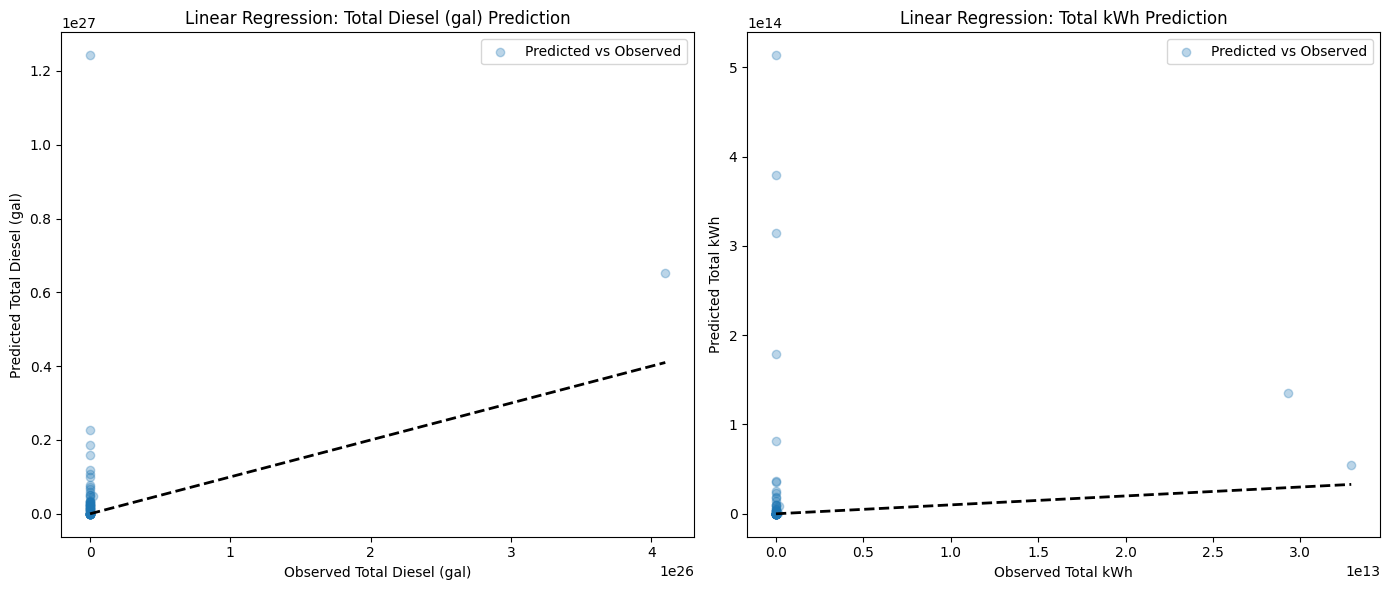

In [117]:
# Plot results for Linear Regression
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Total Diesel (gal)
ax[0].scatter(y_test.iloc[:, 0], y_pred_lr[:, 0], alpha=0.3, label='Predicted vs Observed')
ax[0].plot([y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()],
           [y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 'k--', lw=2)
ax[0].set_xlabel('Observed Total Diesel (gal)')
ax[0].set_ylabel('Predicted Total Diesel (gal)')
ax[0].set_title('Linear Regression: Total Diesel (gal) Prediction')
ax[0].legend()

# Plot for Total kWh
ax[1].scatter(y_test.iloc[:, 1], y_pred_lr[:, 1], alpha=0.3, label='Predicted vs Observed')
ax[1].plot([y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()],
           [y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 'k--', lw=2)
ax[1].set_xlabel('Observed Total kWh')
ax[1].set_ylabel('Predicted Total kWh')
ax[1].set_title('Linear Regression: Total kWh Prediction')
ax[1].legend()
#ax[1].set_xlim(0, 3e13)  # Set x-axis limit
#ax[1].set_ylim(0, 3e13)  # Set y-axis limit

plt.tight_layout()
plt.show()

## Random forest prediction model results

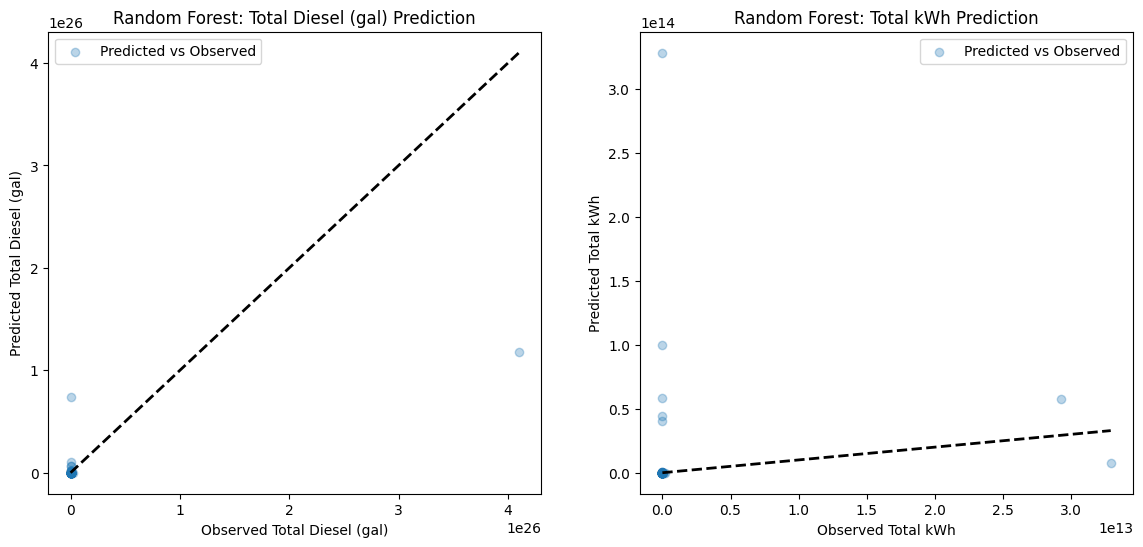

In [112]:
# Plot results for Random Forest
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Total Diesel (gal)
ax[0].scatter(y_test.iloc[:, 0], y_pred_rf[:, 0], alpha=0.3, label='Predicted vs Observed')
ax[0].plot([y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()],
           [y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 'k--', lw=2)
ax[0].set_xlabel('Observed Total Diesel (gal)')
ax[0].set_ylabel('Predicted Total Diesel (gal)')
ax[0].set_title('Random Forest: Total Diesel (gal) Prediction')
ax[0].legend()

# Plot for Total kWh
ax[1].scatter(y_test.iloc[:, 1], y_pred_rf[:, 1], alpha=0.3, label='Predicted vs Observed')
ax[1].plot([y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()],
           [y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 'k--', lw=2)
ax[1].set_xlabel('Observed Total kWh')
ax[1].set_ylabel('Predicted Total kWh')
ax[1].set_title('Random Forest: Total kWh Prediction')
ax[1].legend()

C:\Users\Mahsa\anaconda3\envs\ox\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


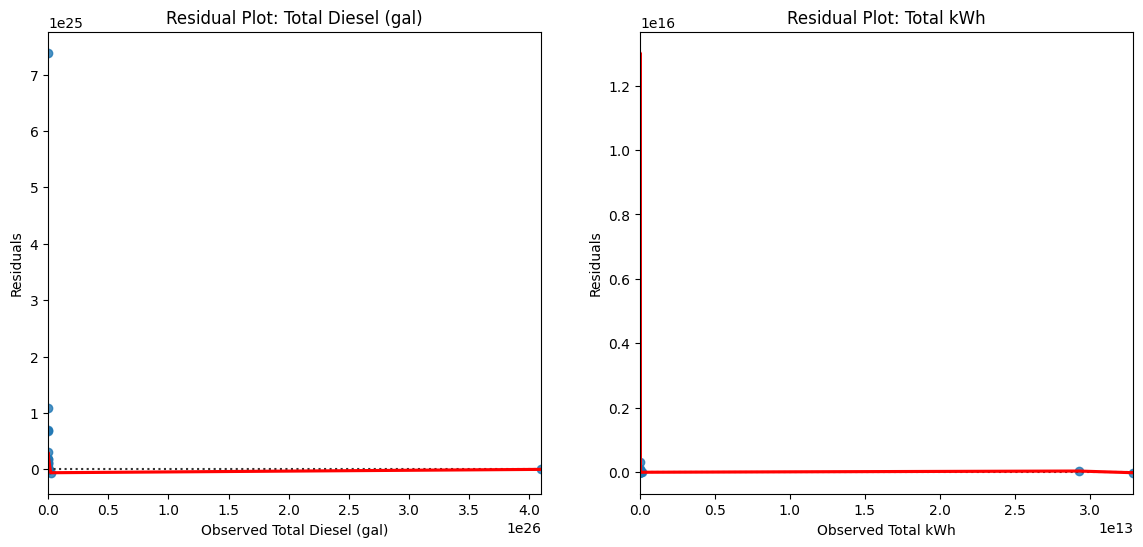

In [113]:
# Residual Plots
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.residplot(x=y_test['Total Diesel (gal)'], y=y_pred_rf[:, 0], lowess=True, line_kws={'color': 'red'})
plt.title('Residual Plot: Total Diesel (gal)')
plt.xlabel('Observed Total Diesel (gal)')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.residplot(x=y_test['Total kWh'], y=y_pred_rf[:, 1], lowess=True, line_kws={'color': 'red'})
plt.title('Residual Plot: Total kWh')
plt.xlabel('Observed Total kWh')
plt.ylabel('Residuals')
plt.show()

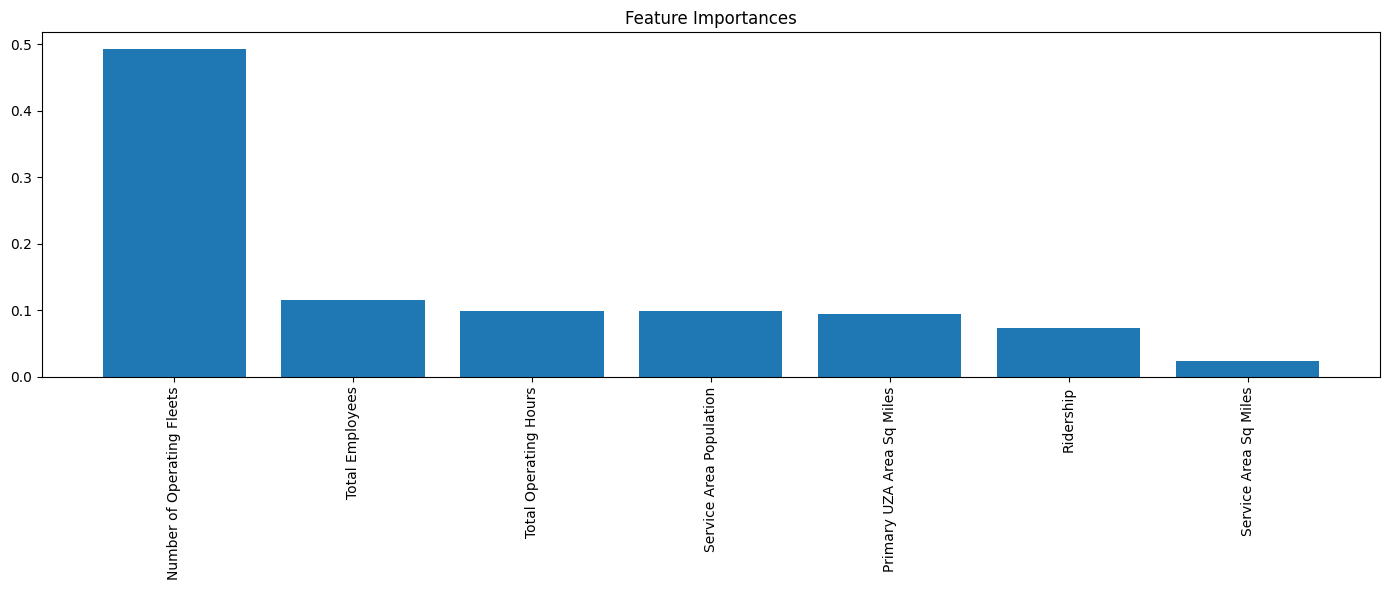

In [114]:
# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(14, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

# Next steps:
### Inspect outliers.
### Explore combining highly correlated features using PCA or selecting a subset based on their importance.
### Investigate additional data sources or features such as weather that might influence Total Diesel (gal).
### Try advanced regression techniques such as Ridge Regression, Lasso Regression, or Gradient Boosting, which can handle multicollinearity and complex patterns better.
### Use cross-validation to ensure that the model generalizes well.

# Ridge regression model

In [131]:
# Initialize and train Ridge Regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Make predictions with Ridge
y_pred_ridge = ridge.predict(X_test)

# Ensure non-negative predictions
y_pred_ridge = np.maximum(0, y_pred_ridge)

# Calculate R² score for Ridge
r2_ridge_diesel = r2_score(y_test['Total Diesel (gal)'], y_pred_ridge[:, 0])
r2_ridge_kwh = r2_score(y_test['Total kWh'], y_pred_ridge[:, 1])
print(f"R² for Total Diesel (gal) with Ridge: {r2_ridge_diesel}")
print(f"R² for Total kWh with Ridge: {r2_ridge_kwh}")

R² for Total Diesel (gal) with Ridge: -9.839459742528236
R² for Total kWh with Ridge: -298.581134759422


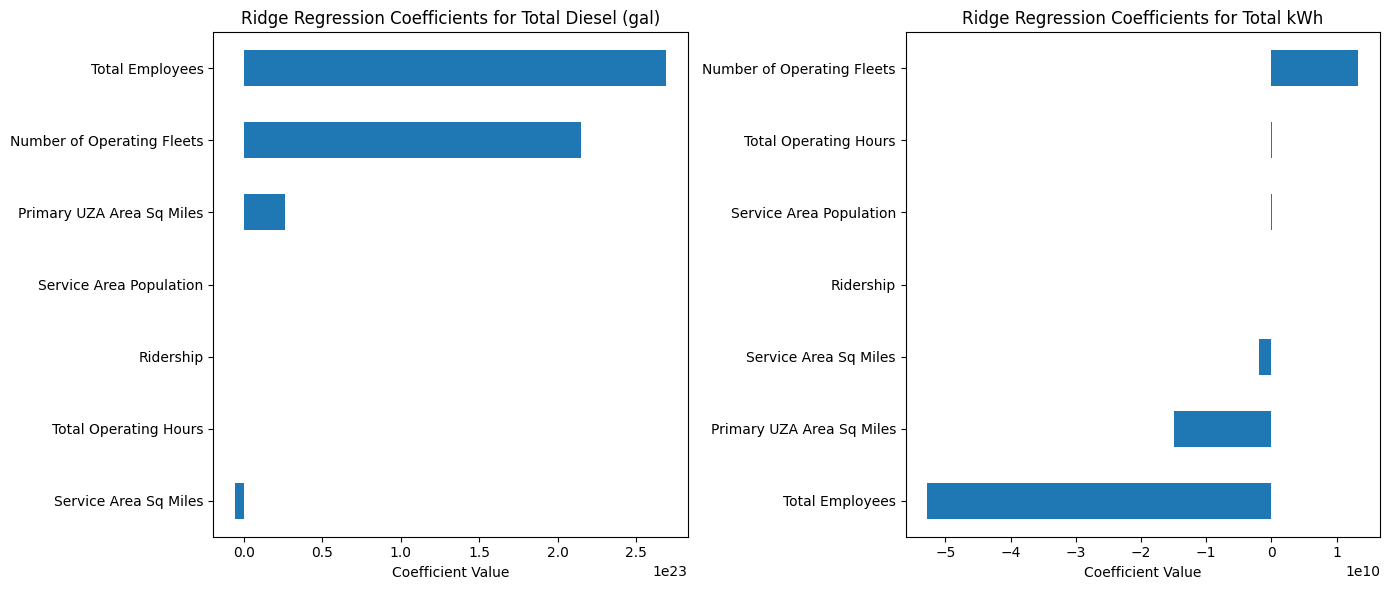

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [132]:
# Plotting coefficients for Ridge Regression
coefficients_ridge = pd.DataFrame(ridge.coef_, columns=X.columns, index=['Total Diesel (gal)', 'Total kWh']).T
plt.figure(figsize=(14, 6))
# Plot for Ridge Regression Coefficients
plt.subplot(1, 2, 1)
coefficients_ridge.iloc[:, 0].sort_values().plot(kind='barh', title='Ridge Regression Coefficients for Total Diesel (gal)')
plt.xlabel('Coefficient Value')

plt.subplot(1, 2, 2)
coefficients_ridge.iloc[:, 1].sort_values().plot(kind='barh', title='Ridge Regression Coefficients for Total kWh')
plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

# Lasso regression model

In [133]:
# Initialize and train Lasso Regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Make predictions with Lasso
y_pred_lasso = lasso.predict(X_test)

# Ensure non-negative predictions
y_pred_lasso = np.maximum(0, y_pred_lasso)

# Calculate R² score for Lasso
r2_lasso_diesel = r2_score(y_test['Total Diesel (gal)'], y_pred_lasso[:, 0])
r2_lasso_kwh = r2_score(y_test['Total kWh'], y_pred_lasso[:, 1])
print(f"R² for Total Diesel (gal) with Lasso: {r2_lasso_diesel}")
print(f"R² for Total kWh with Lasso: {r2_lasso_kwh}")

R² for Total Diesel (gal) with Lasso: -9.926741639747648
R² for Total kWh with Lasso: -296.73239687858336


C:\Users\Mahsa\anaconda3\envs\ox\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e+55, tolerance: 5.334e+51
  model = cd_fast.enet_coordinate_descent(
C:\Users\Mahsa\anaconda3\envs\ox\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.250e+30, tolerance: 6.168e+26
  model = cd_fast.enet_coordinate_descent(


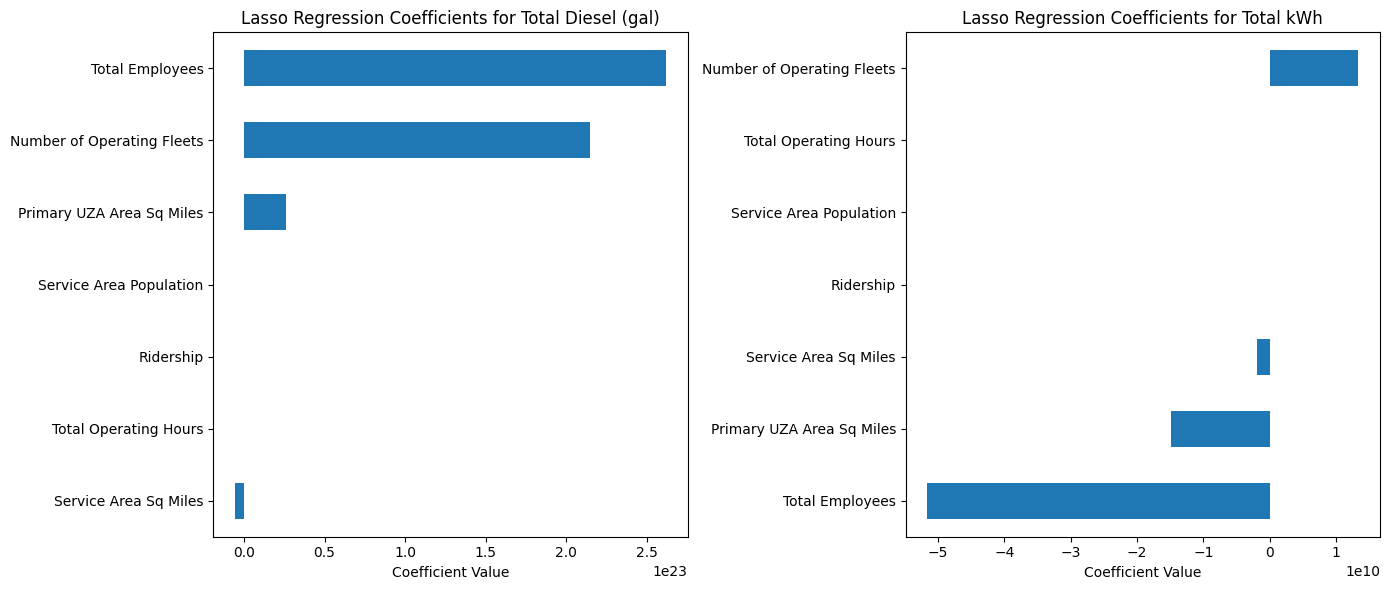

In [134]:
# Plotting coefficients for Lasso Regression
coefficients_lasso = pd.DataFrame(lasso.coef_, columns=X.columns, index=['Total Diesel (gal)', 'Total kWh']).T


plt.figure(figsize=(14, 6))

# Plot for Lasso Regression Coefficients
plt.subplot(1, 2, 1)
coefficients_lasso.iloc[:, 0].sort_values().plot(kind='barh', title='Lasso Regression Coefficients for Total Diesel (gal)')
plt.xlabel('Coefficient Value')

plt.subplot(1, 2, 2)
coefficients_lasso.iloc[:, 1].sort_values().plot(kind='barh', title='Lasso Regression Coefficients for Total kWh')
plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

# Implementing feature engineering

# PCA

In [140]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction using PCA
pca = PCA(n_components=5)  # Keep 5 principal components
X_pca = pca.fit_transform(X_scaled)

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

Explained variance ratio: [0.6318804  0.17232014 0.12901978 0.04801692 0.0168195 ]
Cumulative explained variance: [0.6318804  0.80420054 0.93322031 0.98123724 0.99805673]


## PCA analysis:
### Explained Variance Ratio
### The explained variance ratio for each principal component represents the proportion of the dataset's total variance that is captured by that component:
### The first principal component explains 63.19% of the variance.
### The second principal component explains 17.23% of the variance.
### The third principal component explains 12.90% of the variance.
### The fourth principal component explains 4.80% of the variance.
### The fifth principal component explains 1.68% of the variance.
### Cumulative Explained Variance

## The cumulative explained variance represents the total variance captured by the first n principal components:
### The first principal component captures 63.19% of the variance.
### The first two principal components together capture 80.42% of the variance.
### The first three principal components together capture 93.32% of the variance.
### The first four principal components together capture 98.12% of the variance.
### The first five principal components together capture 99.81% of the variance.


### Variance captured: The first five principal components capture almost all the variance (99.81%) in the data. This means we can effectively reduce the dimensionality of the dataset from the original number of features to just five principal components without losing significant information.
### Dimensionality reduction: By using these five principal components, we can simplify the models, reduce overfitting, and improve computational efficiency while retaining most of the important information in the data.

In [145]:
# Print PCA components
pca_components = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
print(pca_components)
### The five principal components (PC1 to PC5) are linear combinations of the original seven features (Total Operating Hours, Total Employees, Number of Operating Fleets, Ridership, Service Area Population, Service Area Sq Miles, and Primary UZA Area Sq Miles).

     Total Operating Hours  Total Employees  Number of Operating Fleets  \
PC1               0.460470         0.458667                    0.443590   
PC2              -0.187275        -0.192634                   -0.154682   
PC3               0.046392         0.049106                    0.121888   
PC4              -0.077444        -0.077311                   -0.084491   
PC5              -0.340934        -0.391594                    0.847277   

     Ridership  Service Area Population  Service Area Sq Miles  \
PC1   0.463761                 0.334830               0.089295   
PC2  -0.169692                 0.474828               0.634245   
PC3   0.060430                -0.130392               0.705362   
PC4  -0.060899                 0.803106              -0.297274   
PC5  -0.089050                 0.005449              -0.062052   

     Primary UZA Area Sq Miles  
PC1                   0.213687  
PC2                   0.497363  
PC3                  -0.679992  
PC4                 

## Ridge and lasso regression on PCA-transformed data

In [146]:
# Split the data into training and testing sets using PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [147]:
# Initialize and train Ridge Regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Make predictions with Ridge
y_pred_ridge = ridge.predict(X_test)

# Ensure non-negative predictions
y_pred_ridge = np.maximum(0, y_pred_ridge)

# Calculate R² score for Ridge
r2_ridge_diesel = r2_score(y_test['Total Diesel (gal)'], y_pred_ridge[:, 0])
r2_ridge_kwh = r2_score(y_test['Total kWh'], y_pred_ridge[:, 1])
print(f"R² for Total Diesel (gal) with Ridge: {r2_ridge_diesel}")
print(f"R² for Total kWh with Ridge: {r2_ridge_kwh}")

R² for Total Diesel (gal) with Ridge: -1.4488468319263137
R² for Total kWh with Ridge: -99.67150482468665


In [149]:
# Initialize and train Lasso Regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Make predictions with Lasso
y_pred_lasso = lasso.predict(X_test)

# Ensure non-negative predictions
y_pred_lasso = np.maximum(0, y_pred_lasso)

# Calculate R² score for Lasso
r2_lasso_diesel = r2_score(y_test['Total Diesel (gal)'], y_pred_lasso[:, 0])
r2_lasso_kwh = r2_score(y_test['Total kWh'], y_pred_lasso[:, 1])
print(f"R² for Total Diesel (gal) with Lasso: {r2_lasso_diesel}")
print(f"R² for Total kWh with Lasso: {r2_lasso_kwh}")

R² for Total Diesel (gal) with Lasso: -1.5907915892451818
R² for Total kWh with Lasso: -100.01109074574444


C:\Users\Mahsa\anaconda3\envs\ox\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e+55, tolerance: 5.334e+51
  model = cd_fast.enet_coordinate_descent(


## Random forest using PCA-transformed data

In [152]:
# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and testing sets using PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions with Random Forest
y_pred_rf = rf.predict(X_test)

# Ensure non-negative predictions
y_pred_rf = np.maximum(0, y_pred_rf)

# Calculate R² score for Random Forest
r2_rf_diesel = r2_score(y_test['Total Diesel (gal)'], y_pred_rf[:, 0])
r2_rf_kwh = r2_score(y_test['Total kWh'], y_pred_rf[:, 1])
print(f"R² for Total Diesel (gal) with Random Forest: {r2_rf_diesel}")
print(f"R² for Total kWh with Random Forest: {r2_rf_kwh}")

R² for Total Diesel (gal) with Random Forest: -0.1327273978639063
R² for Total kWh with Random Forest: -52.926443960914185


In [154]:
# Feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index=[f'PC{i+1}' for i in range(X_pca.shape[1])], columns=['Importance'])
print("Feature Importances:\n", feature_importances.sort_values(by='Importance', ascending=False))


Feature Importances:
      Importance
PC5    0.862810
PC1    0.050396
PC2    0.036696
PC4    0.026479
PC3    0.023619


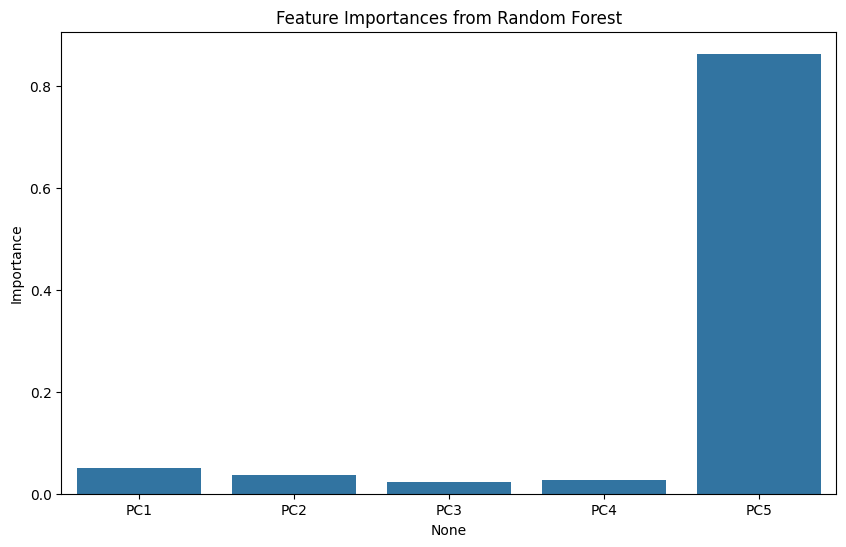

In [155]:
# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.index, y=feature_importances['Importance'])
plt.title('Feature Importances from Random Forest')
plt.show()

# Next steps for model improvement:
## Investigate additional data sources or features such as weather that might influence Total Diesel (gal).
## Outlier detection and handling/removal
## Experiment with more complex models such as Gradient Boosting, and Neural Networks
## Hyperparameter tuning
## Using Cross-Validation